In [1]:
from daqx.util import createDevice
import time
import numpy as np
from matplotlib import pyplot as plt

### General DAQ setup

In [2]:
daq = createDevice('mcc',0)
daq.config_ai(0,2)
daq.config_ao(0,1)

In [3]:
def foo(eventdata,*arg,**kwarg):
    #print('callback executed')
    if eventdata['event'] == 'samplesAcquiredFcn':
        print(f'{time.ctime(eventdata["time"])}: {eventdata["event"]} called at {eventdata["samplesAcquired"]}')
    else:
        print(f'{time.ctime(eventdata["time"])}: {eventdata["event"]} called with arg = {"".join(arg)}')

def collectdata(eventdata,ai,N,obj):
    print(f'{time.ctime(eventdata["time"])}: {eventdata["event"]} called at {eventdata["samplesAcquired"]}')
    timept, data = ai.getdata(N)
    obj.time = np.hstack((obj.time,timept))
    obj.data = np.hstack((obj.data,data))

class daqdata:
    def __init__(self,t,d):
        self.time = t
        self.data = d
   
aidata = daqdata([],[[],[],[]])

### Set up AI

In [4]:
'''
Note - aitime generation may not be accurate at trigger freq of > 10Hz...
     - at high AI sampleRate + trigger frequency, the samplesAcquiredFcn and other processes could be dropped...
     - Need to avoid repetitive fast triggering event
'''
daq.ai.sampleRate = 1000 # Hz/channel
daq.ai.grounding = 'single-ended' #e.g. single_ended
daq.ai.iscontinuous = True # if True -> Inf
#daq.ai.trigType = 'instant'
daq.ai.trigType = 'digital-positive-edge'
daq.ai.trigRepeat = 1
#daq.ai.trigFcn = (foo,'AItrig')
daq.ai.samplesPerTrig = 990 # in samples/channel
daq.ai.samplesAcquiredFcnCount = 900 # in samples/channel; 0 means no function to be called
#daq.ai.samplesAcquiredFcn = (foo,) # ',' makes it a tuple
daq.ai.samplesAcquiredFcn = (collectdata,(daq.ai,daq.ai.samplesAcquiredFcnCount,aidata))
# daq.ai.samplesAcquiredFcn = None
daq.ai.startFcn = (foo,'AIstart')
daq.ai.stopFcn = (foo,'AIstop')
#daq.ai.aqMode = 'foreground' # acquisition mode
daq.ai.aqMode = 'background' # acquisition mode  

### Set up AO

In [5]:
# Parameters
F1 = 10  # Hz
A1 = 5.0  # +/- amplitude
offset1 = 0  # No offset
aoSR = 1000  # Hz
duration = 1 # sec
num_samples = int(aoSR * duration)

# Generate a sine wave buffer
t = np.linspace(0, duration, num_samples, endpoint=False)  # Time vector for cycle * one period
aodata = np.zeros((2,int(aoSR * duration))) #2 channels
aodata[0,0:5] = 4 #trigger points
aodata[1,:] = A1 * np.sin(2 * np.pi * F1 * t) + offset1 #sine wave

# Plotting
# fig = plt.figure()
# plt.plot(t,aodata[0,:])
# plt.plot(t,aodata[1,:],color = 'r')
# plt.grid(True)
# fig.canvas.toolbar_position = 'top'

# Prep AO
daq.ao.sampleRate = aoSR
daq.ao.endMode = 'zero'
daq.ao.startFcn = (foo,'AOstart')
daq.ao.stopFcn = (foo,'AOstop')

daq.ao.putdata(aodata)

### Start AI,AO

In [18]:
aidata.time = []
aidata.data = [[],[],[]]
daq.ai.start()
daq.ao.start()

Fri Jan 24 22:30:05 2025: AIstartFcn called with arg = AIstart
Fri Jan 24 22:30:05 2025: AOstartFcn called with arg = AOstart


Fri Jan 24 22:30:06 2025: samplesAcquiredFcn called at 938
Fri Jan 24 22:30:07 2025: samplesAcquiredFcn called at 1962
Fri Jan 24 22:30:07 2025: samplesAcquiredFcn called at 2730
Fri Jan 24 22:30:08 2025: samplesAcquiredFcn called at 3754
Fri Jan 24 22:30:09 2025: samplesAcquiredFcn called at 4522
Fri Jan 24 22:30:10 2025: samplesAcquiredFcn called at 5461
Fri Jan 24 22:30:11 2025: samplesAcquiredFcn called at 6314


In [19]:
daq.ai.stop()
daq.ao.stop()

Acquisition is done
win buffer freed
Fri Jan 24 22:30:12 2025: AIstopFcn called with arg = AIstop
Fri Jan 24 22:30:12 2025: AOstopFcn called with arg = AOstop


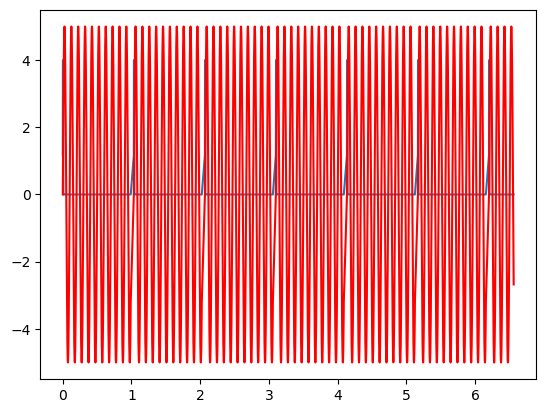

In [20]:
# print(len(daq.ai.data[0]))
# print(len(daq.ai.data[1]))
# plt.figure()
# plt.plot(daq.ai.data[0])
# plt.plot(daq.ai.data[1],'r')
#aitime, aidata = daq.ai.getdata()
plt.figure()
plt.plot(aidata.time,aidata.data[0])
plt.plot(aidata.time,aidata.data[1],'r')

In [21]:
t0 = daq.ai._trigTime[0]
trigtime = [t-t0 for t in daq.ai._trigTime]
print(trigtime)
print(aidata.data.shape)
print(aidata.time.shape)

[0.0, 1.0344138145446777, 2.0691378116607666, 3.101548671722412, 4.136631488800049, 5.169343709945679, 6.2038915157318115]
(3, 6300)
(6300,)


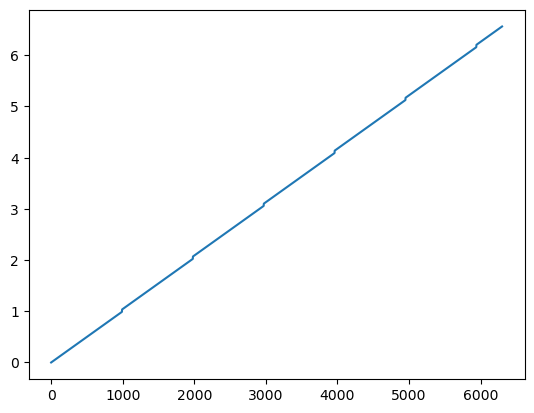

In [22]:
plt.figure()
plt.plot(aidata.time)

In [17]:
plt.close('all')